# L1 filtering schemes

## Application to trend-stationary process

### Model 1 with HP Filter

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.optimize import minimize
import cvxpy as cp
from scipy.sparse import diags
from scipy.sparse import spdiags
import yfinance as yf

In [12]:
# Génération des données du Modèle 1
def generate_model1_data(n, sigma, p, b):
    """
    Génère des données selon le modèle 1 avec des tendances perturbées.
    """
    #np.random.seed(42)
    x_t = np.zeros(n)
    v_t = np.random.uniform(-b / 2, b / 2)
    for t in range(1, n):
        if np.random.rand() < p:
            x_t[t] = x_t[t - 1] + v_t
        else:
            v_t = np.random.uniform(-b / 2, b / 2)
            x_t[t] = x_t[t - 1] + v_t
    noise = np.random.normal(0, sigma, n)
    y_t = x_t + noise
    return x_t, y_t

# Génération des données du Modèle 2
def generate_model2_data(n, sigma, p, b):
    """
    Génère des données selon le modèle 2 avec une marche aléatoire perturbée.
    """
    np.random.seed(42)
    y_t = np.zeros(n)
    v_t = np.random.uniform(-b / 2, b / 2)
    for t in range(1, n):
        if np.random.rand() < p:
            v_t = v_t
        else:
            v_t = np.random.uniform(-b / 2, b / 2)
        y_t[t] = y_t[t - 1] + v_t + np.random.normal(0, sigma)
    return y_t

In [13]:
# Appliquer le filtre HP
def apply_HP_filter(y, lambda_val):
    """
    Applique le filtre Hodrick-Prescott (HP) à une série temporelle y.
    """
    n = len(y)
    D = diags([1, -2, 1], [0, 1, 2], shape=(n - 2, n))  # Opérateur D
    DTD = D.T @ D  # D^T * D
    I = diags([1], [0], shape=(n, n))  # Matrice identité
    # Résolution de l'équation linéaire pour obtenir x_t
    A = I + lambda_val * DTD
    x = spsolve(A, y)
    return x

def apply_HP_filter_cvxpy(y, lambda_val):
    """
    Applique le filtre Hodrick-Prescott (HP) avec CVXPY pour une valeur donnée de lambda.
    """
    n = len(y)
    # Construction de la matrice D pour la régularisation
    D = spdiags([np.ones(n), -2 * np.ones(n), np.ones(n)], [0, 1, 2], n - 2, n).toarray()
    # Définition de la variable d'optimisation
    x = cp.Variable(n)
    # Fonction objectif
    objective = cp.Minimize(0.5 * cp.sum_squares(y - x) + lambda_val * cp.norm(D @ x, p=2))
    # Problème d'optimisation
    problem = cp.Problem(objective)
    problem.solve(solver=cp.SCS)
    return np.array(x.value), problem.value

# Fonction pour générer la matrice de différences
def getD(n, diff_order=2):
    D = spdiags([np.ones(n), -2 * np.ones(n), np.ones(n)], [0, 1, 2], n - 2, n).toarray()
    for _ in range(diff_order - 2):
        D = np.diff(D, axis=0)
    return D
    
def optimize_l1_filter(y, D, lambda_val, solver=cp.OSQP, lambda_step=0.9, min_lambda=1e-2):
    """
    Optimise le filtre L1 avec ajustement dynamique de lambda en cas de non-convergence.

    Args:
        y (array): Série temporelle.
        D (array): Matrice de différences.
        lambda_val (float): Paramètre de régularisation initial.
        solver (cvxpy solver): Solveur pour l'optimisation.
        lambda_step (float): Facteur de réduction pour lambda en cas de non-convergence.
        min_lambda (float): Valeur minimale de lambda.

    Returns:
        array: Signal optimisé.
    """
    n = len(y)
    y_norm = (y - np.mean(y)) / np.std(y)  # Normalisation des données

    while lambda_val > min_lambda:
        # Définition de la variable d'optimisation
        x = cp.Variable(n)
        objective = cp.Minimize(0.5 * cp.sum_squares(y_norm - x) + lambda_val * cp.norm(D @ x, p=1))
        problem = cp.Problem(objective)
        
        try:
            problem.solve(solver=solver)
            if problem.status == cp.OPTIMAL:
                print(f"Convergence réussie pour lambda = {lambda_val:.2f}")
                return np.array(x.value) * np.std(y) + np.mean(y)  # Dé-normalisation
            else:
                raise cp.SolverError("Solveur non convergent")
        except cp.SolverError:
            print(f"Problème non convergent pour lambda = {lambda_val:.2f}, réduction de lambda...")
            lambda_val *= lambda_step  # Réduction de lambda

    print("Échec de convergence : lambda est descendu en dessous de la borne minimale.")
    return np.zeros(n)  # Retourne un signal nul en cas d'échec complet


def l1tf_mix(x, lambda1, lambda2, k1=1, k2=2):
    """L1 filtering with mixed differences."""
    n_obs = len(x)
    trend = cp.Variable(n_obs)
    obj = (
        0.5 * cp.sum_squares(x - trend)
        + lambda1 * cp.norm1(cp.diff(trend, k=k1))
        + lambda2 * cp.norm1(cp.diff(trend, k=k2))
    )
    prob = cp.Problem(cp.Minimize(obj))
    prob.solve()
    return trend.value

def calibrate_lambda_fixed(y, periods=1, lambda_max_cap=1e4):
    """
    Calibre lambda en fonction d'une période fixe avec une borne maximale pour λ.

    Args:
        y (array): Série temporelle.
        periods (int): Nombre de périodes pour diviser les données.
        lambda_max_cap (float): Borne maximale pour λ.

    Returns:
        lambda_val (float): Valeur moyenne de lambda calibrée.
    """
    n = len(y)
    lambdas = []
    period_size = n // periods

    for i in range(periods):
        start, end = i * period_size, (i + 1) * period_size
        y_segment = y[start:end]
        
        # Normalisation des données pour la stabilité
        y_segment = (y_segment - np.mean(y_segment)) / np.std(y_segment)

        # Recalcule la matrice D pour le segment
        D_segment = getD(len(y_segment), diff_order=2)
        
        # Calcule λmax avec borne
        lambda_max = np.linalg.norm(np.linalg.solve(D_segment @ D_segment.T, D_segment @ y_segment), ord=np.inf)
        lambdas.append(min(lambda_max, lambda_max_cap))  # Cap à lambda_max_cap
    
    lambda_avg = np.mean(lambdas)
    print(f"Calibrated λ (average): {lambda_avg}")
    return lambda_avg

Calibrated λ (average): 780.9041606605572
Convergence réussie pour lambda = 780.90


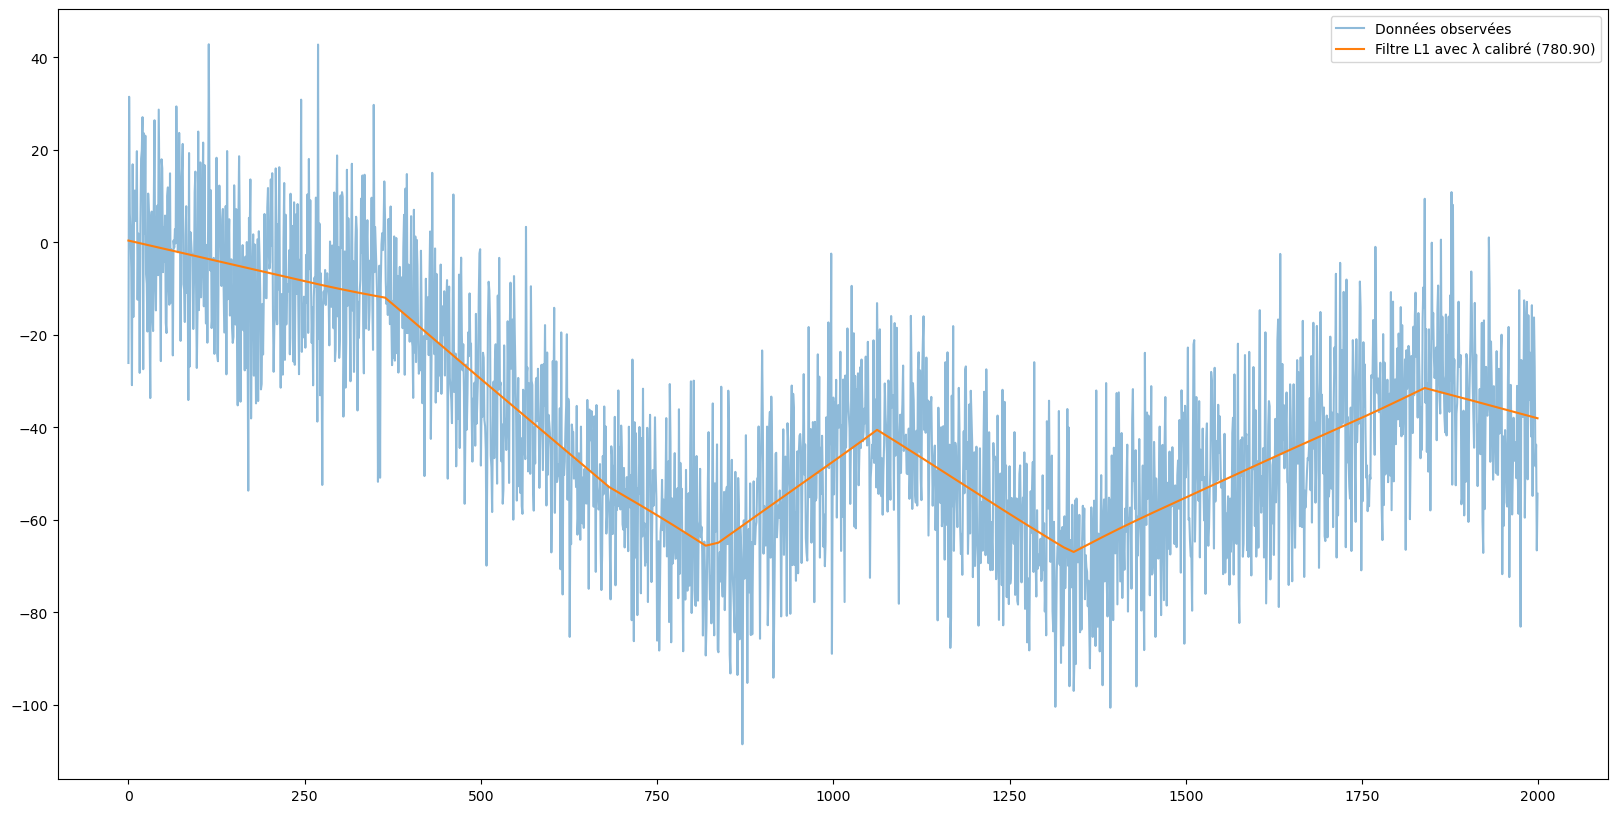

In [15]:
# Données générées
n = 2000
sigma = 15
p = 0.99
b = 0.5
lambda_HP = 1217464  # Paramètre de régularisation pour le filtre HP
x_true, y_data = generate_model1_data(n, sigma, p, b)

# Méthode 1 : Ajustement pour une période donnée avec borne et normalisation
lambda_fixed = calibrate_lambda_fixed(y_data, periods=7, lambda_max_cap=1e4)

# Matrice D pour la série complète
D = getD(n, diff_order=2)

# Applique le filtre L1 avec la nouvelle valeur de λ calibrée
x_filtered_fixed = optimize_l1_filter(y_data, D, lambda_fixed)

# Affiche le résultat
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.plot(y_data, label="Données observées", alpha=0.5)
plt.plot(x_filtered_fixed, label=f"Filtre L1 avec λ calibré ({lambda_fixed:.2f})")
plt.legend()
plt.show()


### Model 2 with HP Filter

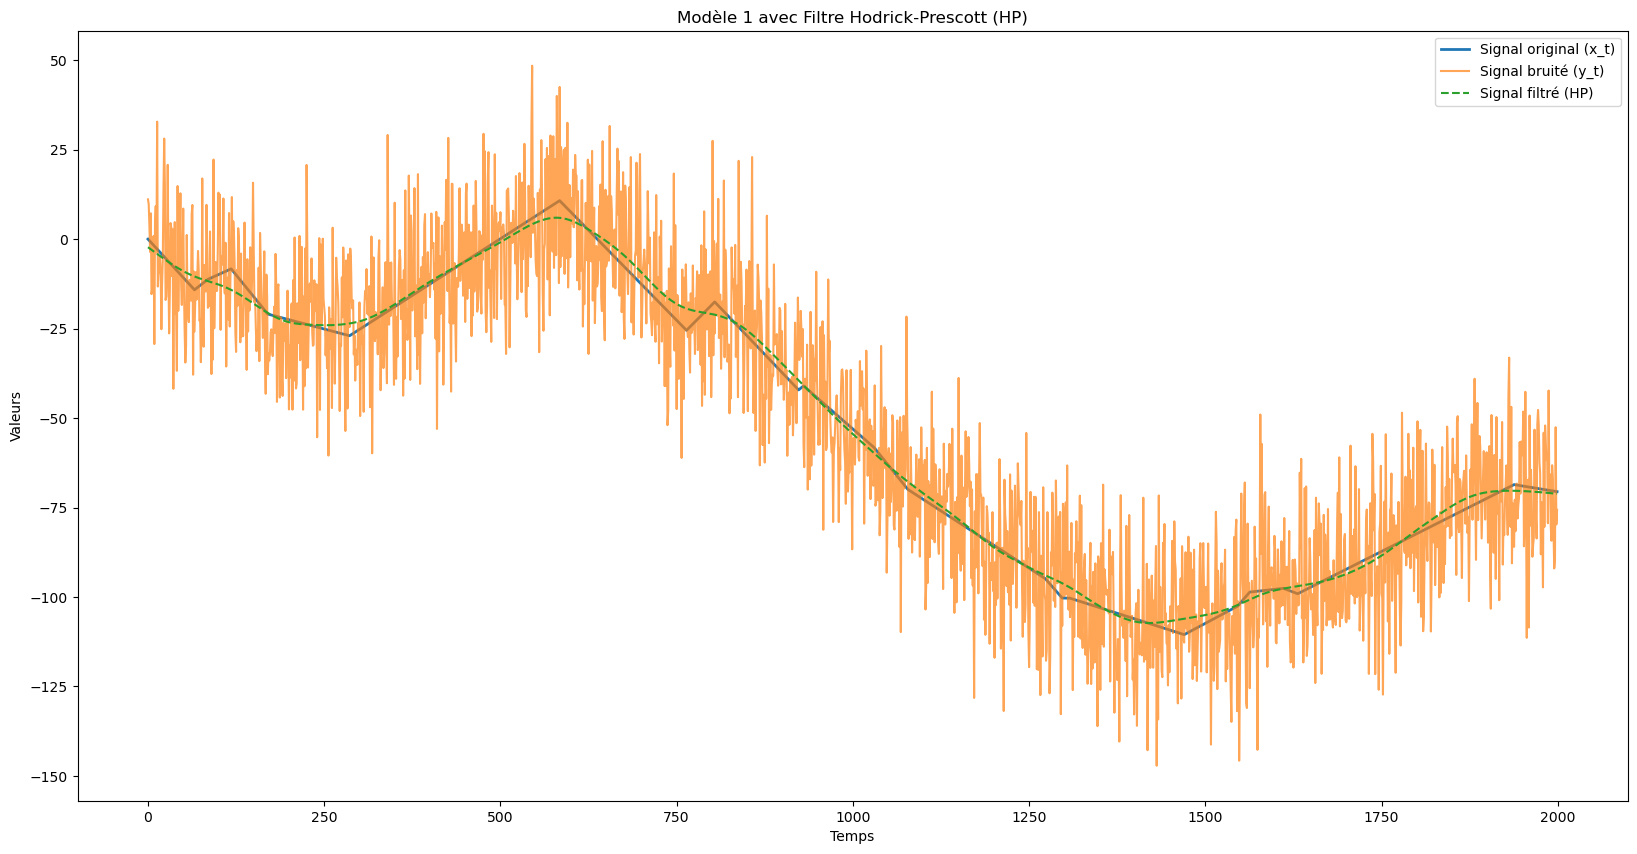

In [16]:
# Générer les données
x_t, y_t = generate_model1_data(n=n, sigma=sigma, p=p, b=b)

# Appliquer le filtre HP
x_HP = apply_HP_filter(y_t, lambda_HP)

# Visualisation des résultats
plt.figure(figsize=(20, 10))
plt.plot(x_t, label="Signal original (x_t)", linewidth=2)
plt.plot(y_t, label="Signal bruité (y_t)", alpha=0.7)
plt.plot(x_HP, label="Signal filtré (HP)", linestyle="--")
plt.legend()
plt.title("Modèle 1 avec Filtre Hodrick-Prescott (HP)")
plt.xlabel("Temps")
plt.ylabel("Valeurs")
plt.show()

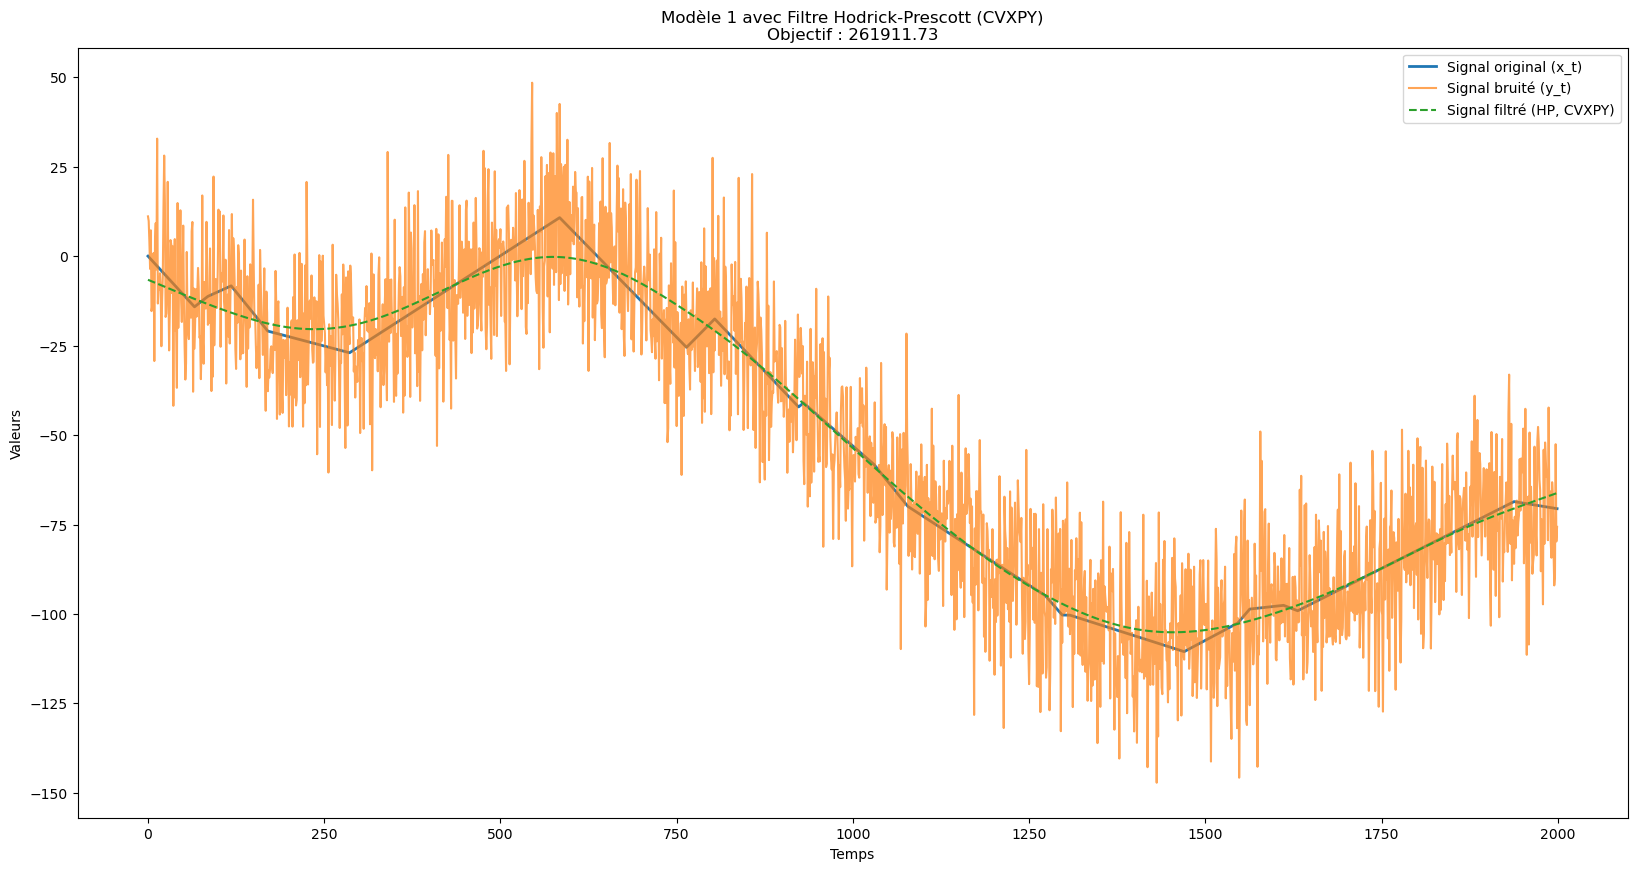

In [17]:
# Appliquer le filtre HP avec CVXPY
x_HP_cvxpy, objective_value = apply_HP_filter_cvxpy(y_t, lambda_HP)

# Visualisation des résultats
plt.figure(figsize=(20, 10))
plt.plot(x_t, label="Signal original (x_t)", linewidth=2)
plt.plot(y_t, label="Signal bruité (y_t)", alpha=0.7)
plt.plot(x_HP_cvxpy, label="Signal filtré (HP, CVXPY)", linestyle="--")
plt.legend()
plt.title(f"Modèle 1 avec Filtre Hodrick-Prescott (CVXPY)\nObjectif : {objective_value:.2f}")
plt.xlabel("Temps")
plt.ylabel("Valeurs")
plt.show()

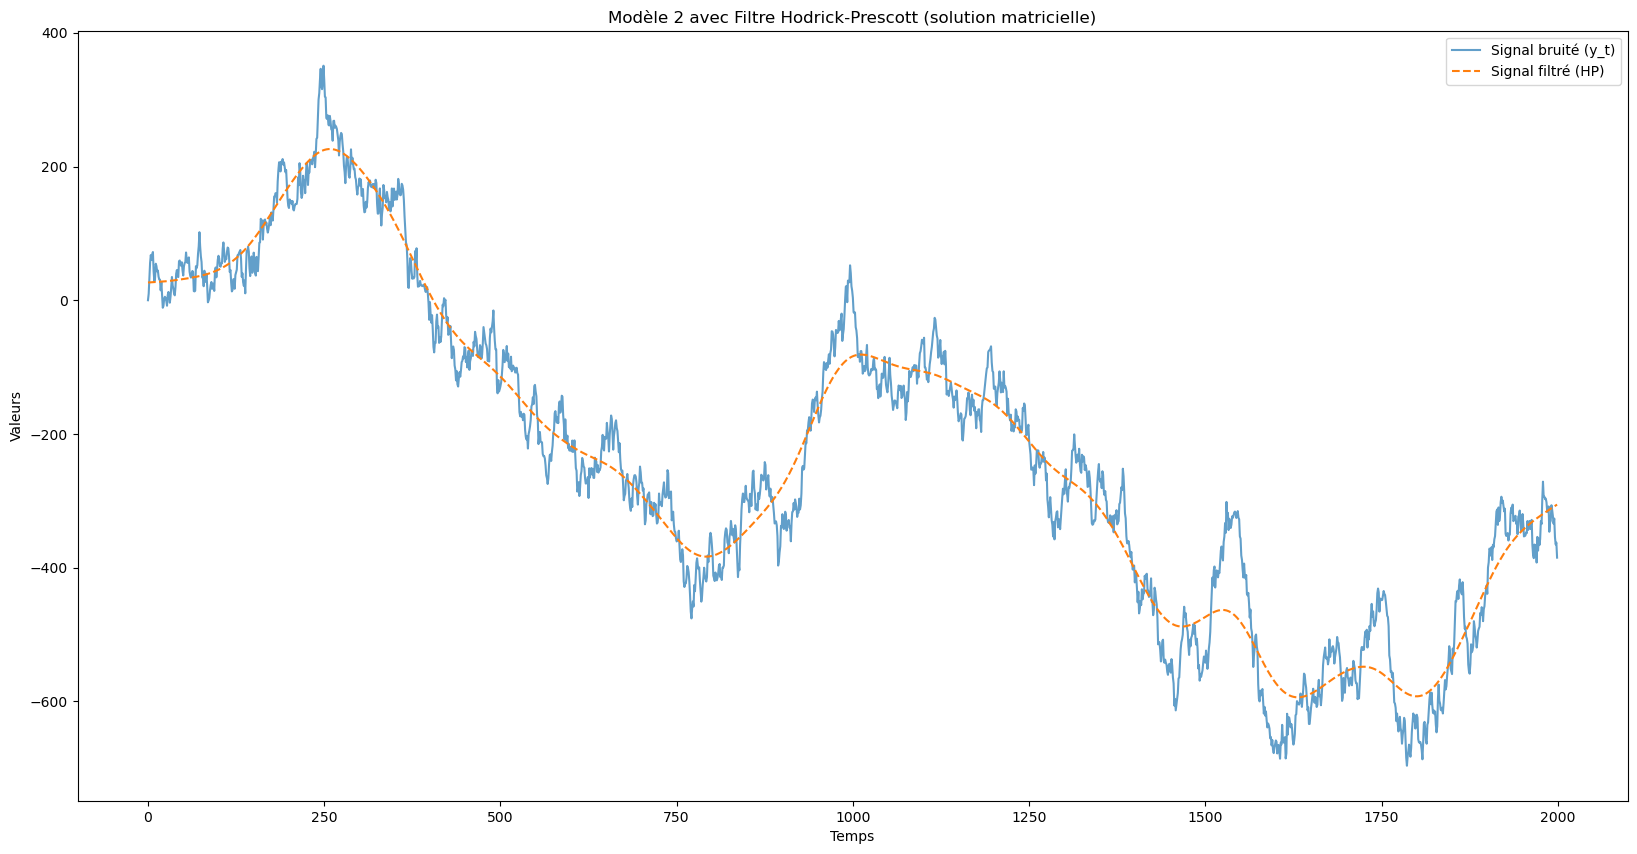

In [18]:
# Générer les données
y_t = generate_model2_data(n=n, sigma=sigma, p=p, b=b)

# Appliquer le filtre HP
x_HP = apply_HP_filter(y_t, lambda_HP)

# Visualisation des résultats
plt.figure(figsize=(20, 10))
plt.plot(y_t, label="Signal bruité (y_t)", alpha=0.7)
plt.plot(x_HP, label="Signal filtré (HP)", linestyle="--")
plt.legend()
plt.title("Modèle 2 avec Filtre Hodrick-Prescott (solution matricielle)")
plt.xlabel("Temps")
plt.ylabel("Valeurs")
plt.show()

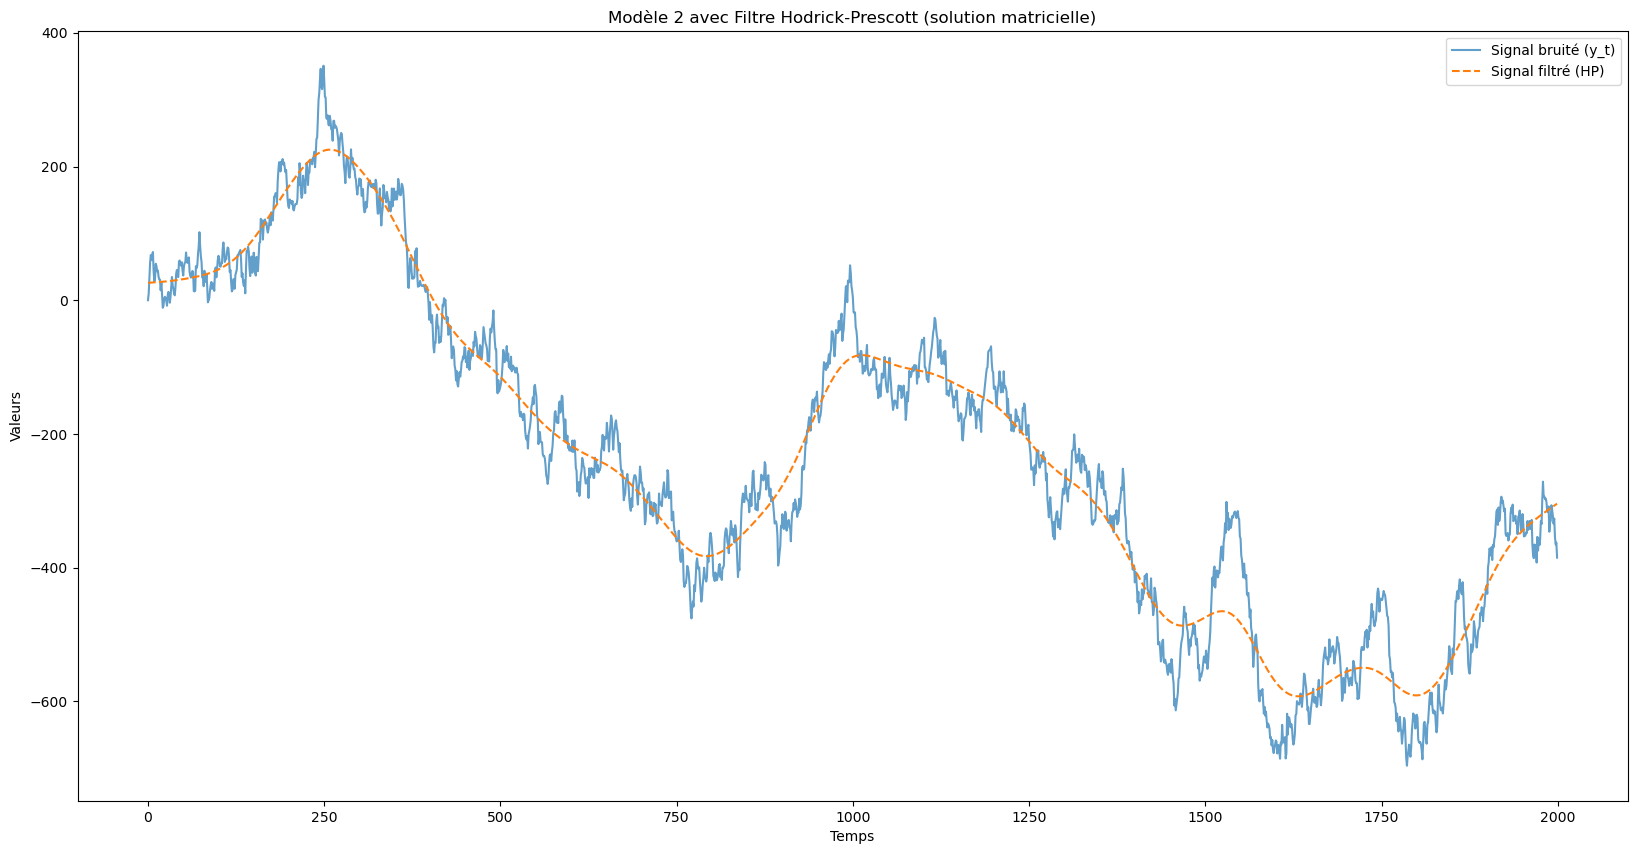

In [19]:
# Générer les données
y_t_model2 = generate_model2_data(n=n, sigma=sigma, p=p, b=b)

# Appliquer le filtre HP
x_filtered, objective_value = apply_HP_filter_cvxpy(y_t_model2, lambda_HP)

# Visualisation des résultats
plt.figure(figsize=(20, 10))
plt.plot(y_t_model2, label="Signal bruité (y_t)", alpha=0.7)
plt.plot(x_filtered, label="Signal filtré (HP)", linestyle="--")
plt.legend()
plt.title("Modèle 2 avec Filtre Hodrick-Prescott (solution matricielle)")
plt.xlabel("Temps")
plt.ylabel("Valeurs")
plt.show()

### L1 filter

In [20]:
# Paramètres d'exécution
n = 2000
sigma = 15
p = 0.99
b = 0.5
T1 = 100
T2 = 20
m = 5
n_lambda = 10

#### Model 1

Calibrated λ (average): 1006.9331928583449
Convergence réussie pour lambda = 1006.93


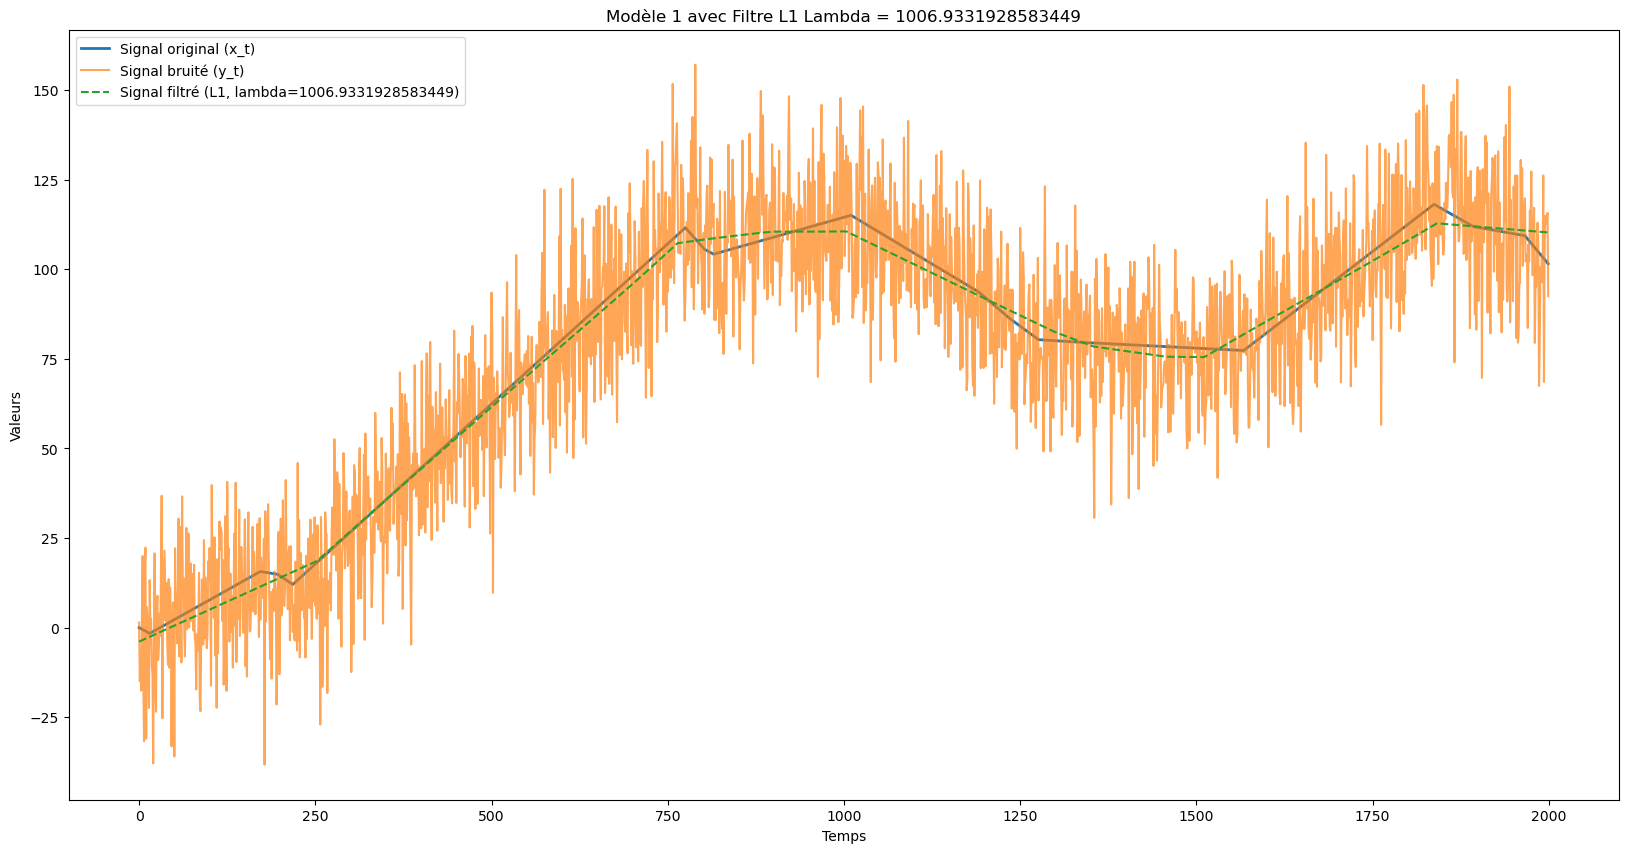

In [21]:
#Générer les données
x_t_model1, y_t_model1 = generate_model1_data(n=n, sigma=sigma, p=p, b=b)
lambda_fixed = calibrate_lambda_fixed(y_t_model1, periods=7, lambda_max_cap=1e4)

# Matrice D pour la série complète
D = getD(n, diff_order=2)

# Appliquer l'optimisation pour une valeur de lambda
x_filtered = optimize_l1_filter(y_t_model1, D, lambda_fixed)

# Graphique des résultats
plt.figure(figsize=(20, 10))
plt.plot(x_t_model1, label="Signal original (x_t)", linewidth=2)
plt.plot(y_t_model1, label="Signal bruité (y_t)", alpha=0.7)
plt.plot(x_filtered, label=f"Signal filtré (L1, lambda={lambda_fixed})", linestyle="--")
plt.legend()
plt.title(f"Modèle 1 avec Filtre L1 Lambda = {lambda_fixed}")
plt.xlabel("Temps")
plt.ylabel("Valeurs")
plt.show()

#### Model 2

Calibrated λ (average): 117.50060698044202
Convergence réussie pour lambda = 117.50


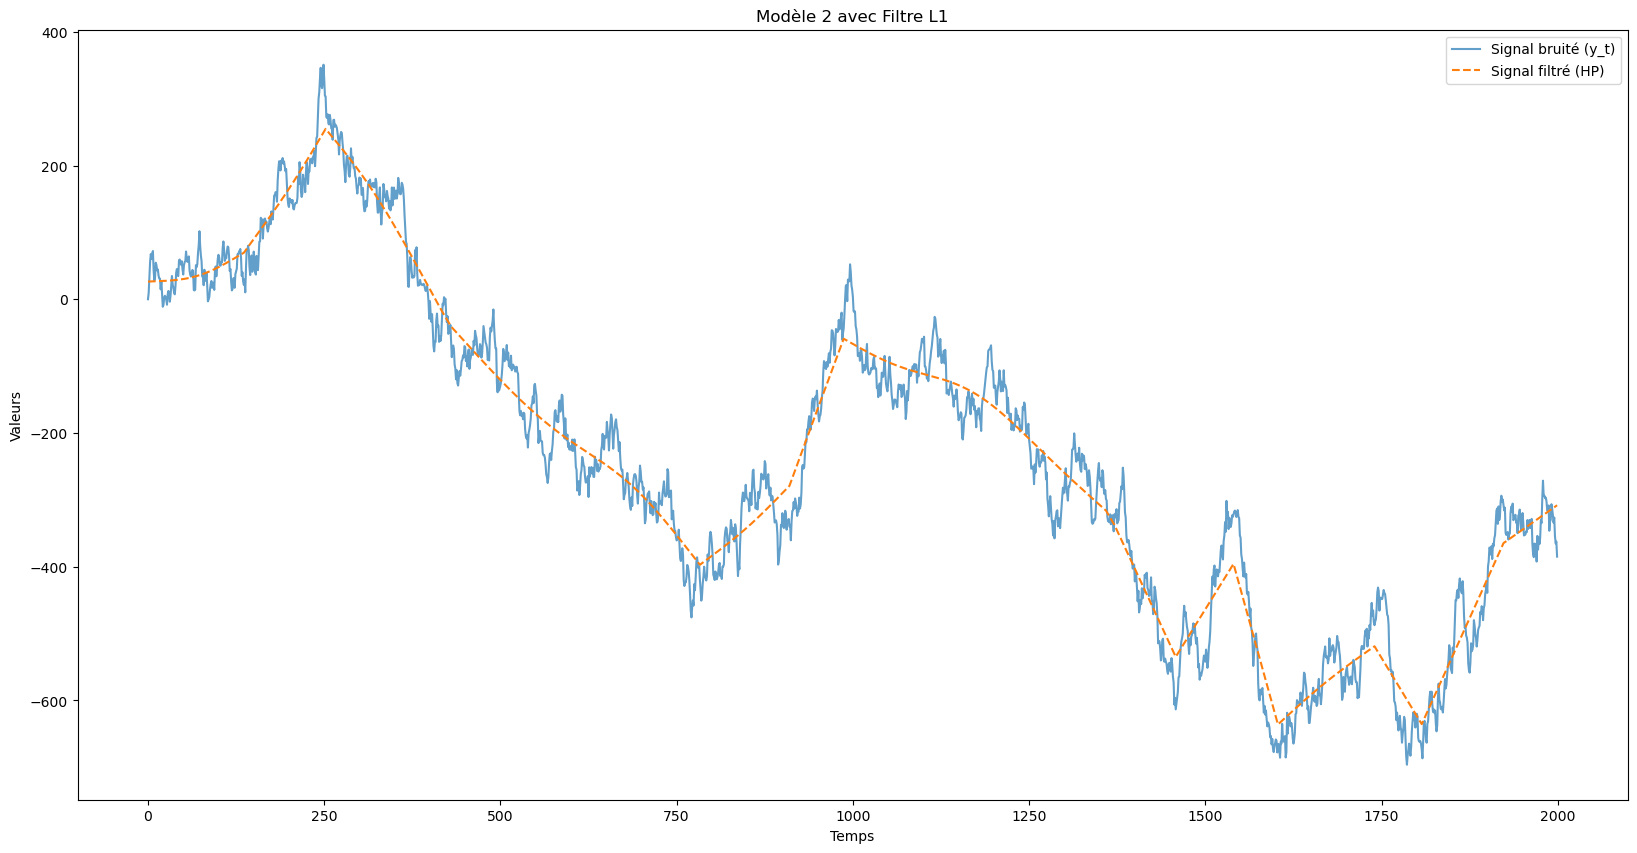

In [22]:
#Générer les données
y_t_model2 = generate_model2_data(n=n, sigma=sigma, p=p, b=b)
lambda_fixed = calibrate_lambda_fixed(y_t_model2, periods=30, lambda_max_cap=1e4)

# Appliquer l'optimisation pour une valeur de lambda
x_filtered = optimize_l1_filter(y_t_model2, D, lambda_fixed)

# Visualisation des résultats
plt.figure(figsize=(20, 10))
plt.plot(y_t_model2, label="Signal bruité (y_t)", alpha=0.7)
plt.plot(x_filtered, label="Signal filtré (HP)", linestyle="--")
plt.legend()
plt.title("Modèle 2 avec Filtre L1")
plt.xlabel("Temps")
plt.ylabel("Valeurs")
plt.show()

[*********************100%%**********************]  1 of 1 completed


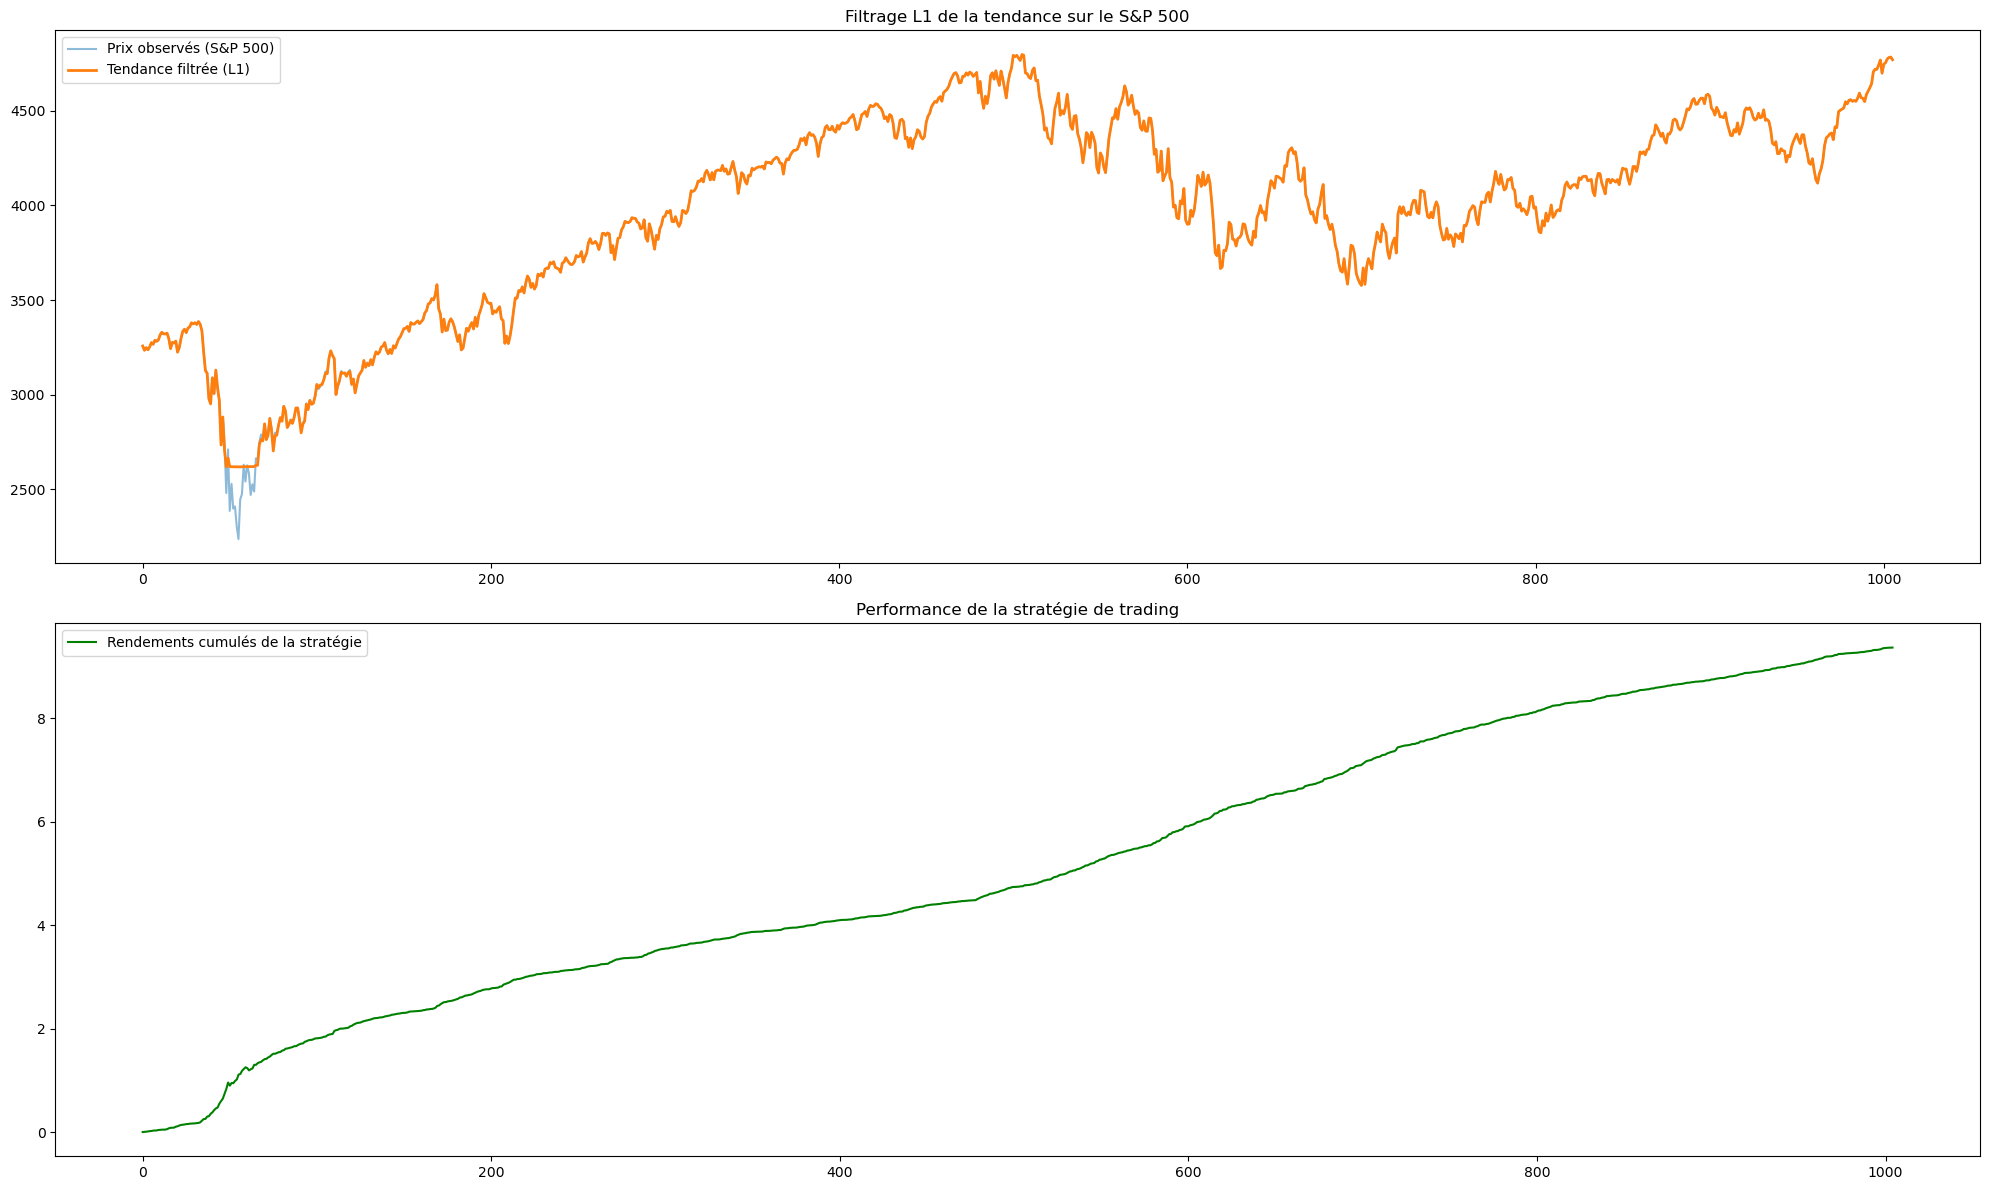

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import scipy.sparse as sp
import scipy.optimize as opt

# ==================== 1. Fonctions auxiliaires ====================

def getD(n, diff_order=2):
    """
    Crée une matrice D de différentiation d'ordre spécifié.
    """
    I = sp.eye(n)
    D = I
    for _ in range(diff_order):
        D = sp.csr_matrix(np.diff(D.toarray(), axis=0))
    return D


def optimize_l1_filter(y, D, lambd):
    """
    Applique un filtre L1 pour débruiter la série temporelle.
    """
    n = len(y)
    P = sp.vstack([sp.eye(n), lambd * D])
    q = np.hstack([y, np.zeros(D.shape[0])])
    
    def objective(x):
        return np.sum(np.abs(P @ x - q))
    
    x0 = np.zeros(n)
    result = opt.minimize(objective, x0, method='SLSQP')
    return result.x


def calibrate_lambda_fixed(data, periods=4):
    """
    Calibre une valeur fixe de lambda basée sur l'écart-type des différences.
    """
    diffs = np.diff(data, n=periods)
    return 1.0 / np.std(diffs)


def trading_strategy(signal, threshold=0):
    """
    Stratégie de trading basée sur la pente du signal filtré.
    Long si la pente est positive, short sinon.
    """
    position = np.sign(np.diff(signal) - threshold)
    position = np.append(position, 0)  # Pas de position au dernier point
    return position


def backtest_strategy(prices, position):
    """
    Backtest simple pour calculer les rendements cumulés de la stratégie.
    """
    returns = np.diff(prices) / prices[:-1]
    strategy_returns = position[:-1] * returns
    cumulative_returns = np.cumsum(strategy_returns)
    return cumulative_returns

# ==================== 2. Récupération des données du S&P 500 ====================

ticker = "^GSPC"  # S&P 500
start_date = "2020-01-01"
end_date = "2024-01-01"

# Téléchargement des données
sp500_data = yf.download(ticker, start=start_date, end=end_date)
prices = sp500_data['Close'].values
n = len(prices)

# ==================== 3. Filtrage de la tendance ====================

# Calibration de lambda
lambda_fixed = calibrate_lambda_fixed(prices, periods=4)

# Application du filtre L1
D = getD(n, diff_order=2)
filtered_signal = optimize_l1_filter(prices, D, lambda_fixed)

# ==================== 4. Stratégie de trading et backtest ====================
positions = trading_strategy(filtered_signal, threshold=0)
cumulative_returns = backtest_strategy(prices, positions)

# ==================== 5. Visualisation ====================

plt.figure(figsize=(20, 12))

# Plot des données et de la tendance filtrée
plt.subplot(2, 1, 1)
plt.plot(prices, label="Prix observés (S&P 500)", alpha=0.5)
plt.plot(filtered_signal, label="Tendance filtrée (L1)", linewidth=2)
plt.title("Filtrage L1 de la tendance sur le S&P 500")
plt.legend()

# Plot des rendements cumulés de la stratégie
plt.subplot(2, 1, 2)
plt.plot(cumulative_returns, label="Rendements cumulés de la stratégie", color='g')
plt.title("Performance de la stratégie de trading")
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
import numpy as np
import pandas as pd
import yfinance as yf
import cvxpy as cp
import matplotlib.pyplot as plt

# 1. Fonction de filtrage L1 pour extraire la tendance
def l1_filter(data, T1, lambda_val):
    """
    Applique un filtre L1 pour la série temporelle.
    T1 : Fenêtre d'estimation.
    lambda_val : Paramètre de régularisation.
    """
    n = len(data)
    x = cp.Variable(n)
    objective = cp.Minimize(0.5 * cp.sum_squares(data - x) + lambda_val * cp.norm1(cp.diff(x, k=2)))
    constraints = [cp.diff(x) >= -T1, cp.diff(x) <= T1]  # Contraintes optionnelles
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.ECOS)
    return x.value

# 2. Stratégie L1 Momentum
def L1_momentum_strategy(data, w0, curr_vars=None, **kwargs):
    """
    Implémente la stratégie L1 Momentum.
    data : Série temporelle log-transformée.
    w0 : Budget initial.
    curr_vars : Variables d'état (pour maintenir les allocations).
    kwargs : Paramètres supplémentaires (T1, T2, etc.).
    """
    T1 = kwargs.get("T1", 130 * 4)  # Valeur par défaut si T1 non spécifié
    T2 = kwargs.get("T2", 130)      # Valeur par défaut si T2 non spécifié
    risk = kwargs.get("risk", 0.001)
    
    log_data = np.log(data)
    trend = l1_filter(log_data, T1, lambda_val=100)
    
    pred_mu = trend[-1] - trend[-2]  # Signal momentum basé sur la tendance
    
    # Calcul de la volatilité
    vol = np.mean(np.diff(log_data[-T2:]) ** 2)
    
    # Allocation basée sur le risque
    asset_alloc = pred_mu / (risk * w0 * vol)
    asset_alloc = np.clip(asset_alloc, -1, 1)  # Allocation contrainte [-1, 1]
    
    return {"asset.alloc": asset_alloc, "trend": trend}

# 3. Stratégie Moving Average
def MA_strategy(data, w0, T1, T2, risk=0.001):
    """
    Stratégie basée sur Moving Average.
    data : Série temporelle.
    T1, T2 : Fenêtres pour estimation.
    """
    log_data = np.log(data)
    ma_trend = log_data[-T1:].mean() - log_data[-T2:].mean()
    vol = np.mean(np.diff(log_data[-T2:]) ** 2)
    asset_alloc = ma_trend / (risk * w0 * vol)
    asset_alloc = np.clip(asset_alloc, -1, 1)
    return asset_alloc, ma_trend

# 4. Backtest des stratégies
def backtest(data, strategy_func, T1, T2, w0=1):
    allocations = []
    trends = []
    
    for t in range(T2, len(data)):
        window_data = data[:t]
        asset_alloc, trend = strategy_func(window_data, w0, T1, T2)
        allocations.append(asset_alloc)
        trends.append(trend)
    
    returns = np.diff(data) / data[:-1]
    strategy_returns = np.array(allocations[:-1]) * returns[-len(allocations[:-1]):]
    cumulative_returns = np.cumprod(1 + strategy_returns) - 1
    return cumulative_returns, trends, allocations



In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Fonction principale de backtest
def backtest(strategy, start, end, data, rf_rate, w0, transact_cost=1e-3, **strategy_params):
    """
    Fonction de backtest pour une stratégie donnée.
    strategy : Fonction représentant la stratégie.
    start : Date de début.
    end : Date de fin.
    data : Série temporelle des prix.
    rf_rate : Taux sans risque.
    w0 : Richesse initiale.
    transact_cost : Coût de transaction.
    strategy_params : Paramètres supplémentaires pour la stratégie.
    """
    # Filtrer les données entre start et end
    data = data.loc[start:end]
    rf_rate = rf_rate.loc[start:end]
    dates = data.index

    signals = []  # Stocker les allocations
    wealth = w0   # Richesse initiale
    day_result = None  # État courant de la stratégie

    print("Début du backtest...")
    for i in range(1, len(dates)):
        print(f"Date: {dates[i]}")
        window_data = data[:i]  # Données historiques jusqu'à la date actuelle
        day_result = strategy(window_data.values, w0, day_result, **strategy_params)  # Passer les params
        alloc = day_result['asset.alloc']
        signals.append(alloc)

    # Résultat du backtest
    results = {
        'backtest_dates': dates[1:],  # Ignorer la première date
        'weights': np.array(signals),
        'risky': data.iloc[1:].values.flatten(),
        'rf': rf_rate.iloc[1:].values.flatten(),
        'initial_wealth': w0,
        'transaction_cost': transact_cost
    }
    return results


# Résumé simple des résultats du backtest
def simple_summary_strat(bt_result):
    """
    Génère un résumé simple des résultats du backtest.
    bt_result : Résultat de la fonction backtest.
    """
    weights = bt_result['weights']
    risky_returns = np.diff(bt_result['risky']) / bt_result['risky'][:-1]
    rf = bt_result['rf']
    
    # Calcul de la richesse
    wealth = [bt_result['initial_wealth']]
    for t in range(len(risky_returns)):
        daily_return = weights[t] * risky_returns[t] + (1 - weights[t]) * rf[t]
        wealth.append(wealth[-1] * (1 + daily_return))
    wealth = np.array(wealth)
    
    # Rendements quotidiens et cumulés
    daily_returns = np.diff(wealth) / wealth[:-1]
    cumulative_returns = wealth / bt_result['initial_wealth'] - 1
    
    # Statistiques de performance
    ret_mean = np.mean(daily_returns)
    vol = np.std(daily_returns)
    sharpe_ratio = ret_mean / vol
    max_drawdown = np.max(1 - wealth / np.maximum.accumulate(wealth))

    stat_vec = {
        'Return': ret_mean,
        'Volatility': vol,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }
    
    # Affichage des graphiques
    plt.figure(figsize=(12, 8))
    plt.subplot(3, 1, 1)
    plt.plot(wealth, label="Wealth")
    plt.title("Évolution de la Richesse")
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(daily_returns, label="Daily Returns")
    plt.title("Rendements Quotidiens")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(weights, label="Weights (Allocations)")
    plt.title("Évolution des Allocations")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("Indicateurs de Performance :")
    for k, v in stat_vec.items():
        print(f"{k}: {v:.6f}")

    return {
        'performance_indicator': stat_vec,
        'daily_return': daily_returns,
        'cumulative_return': cumulative_returns,
        'wealth': wealth
    }


[*********************100%%**********************]  1 of 1 completed

Téléchargement des données...
Début du backtest...


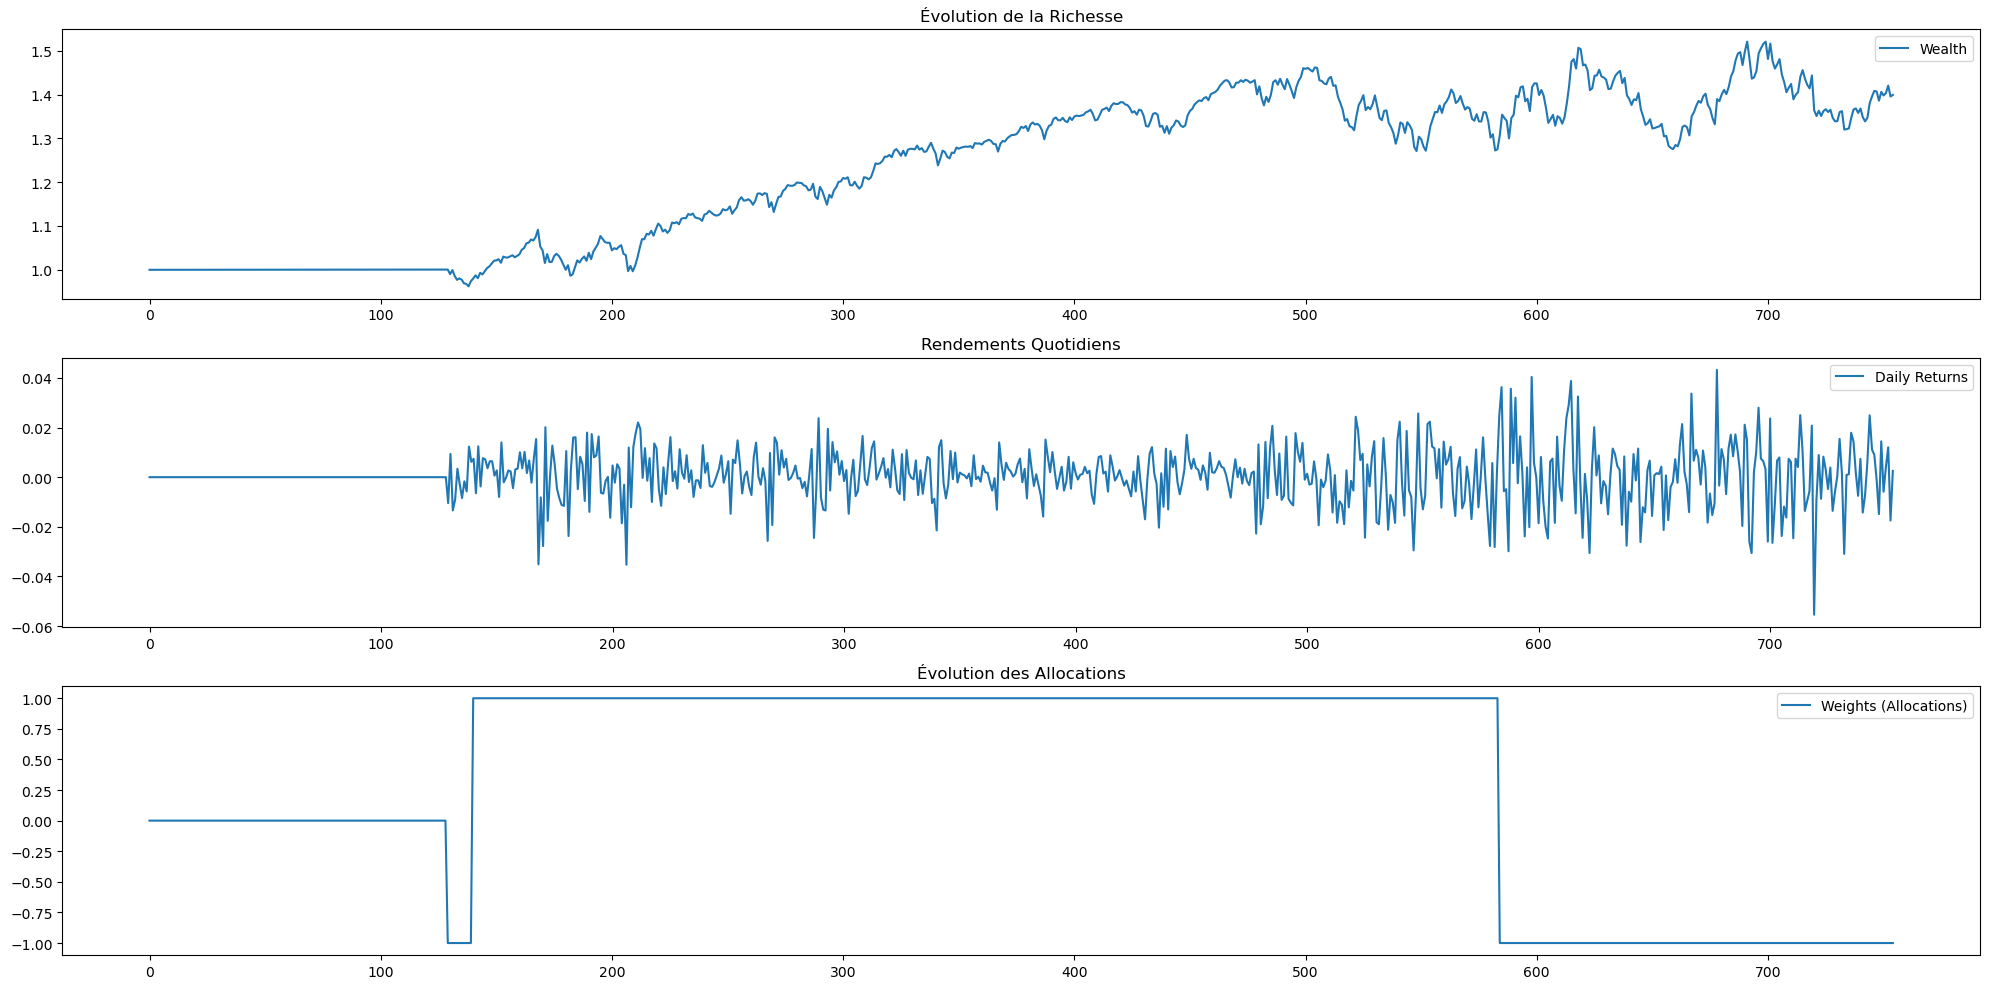

Indicateurs de Performance :
Return: 0.000505
Volatility: 0.010855
Sharpe Ratio: 0.046488
Max Drawdown: 0.153454


In [15]:
import numpy as np
import pandas as pd
import yfinance as yf
import cvxpy as cp
import matplotlib.pyplot as plt

# 1. Fonction de filtrage L1 pour extraire la tendance
def l1_filter(data, lambda_val=100):
    """
    Applique un filtre L1 pour la série temporelle.
    data : Série temporelle brute.
    lambda_val : Paramètre de régularisation.
    """
    n = len(data)
    if n < 3:
        raise ValueError("Les données doivent contenir au moins 3 points pour appliquer le filtre L1.")

    x = cp.Variable(n)
    objective = cp.Minimize(0.5 * cp.sum_squares(data - x) + lambda_val * cp.norm1(cp.diff(x, k=2)))
    problem = cp.Problem(objective)
    problem.solve(solver=cp.ECOS)
    return x.value

# 2. Stratégie L1 Momentum
def L1_momentum_strategy(data, w0, curr_vars=None, **kwargs):
    """
    Implémente la stratégie L1 Momentum.
    data : Série temporelle des prix.
    w0 : Budget initial.
    curr_vars : Variables d'état pour maintenir les allocations.
    kwargs : Paramètres supplémentaires (T1, T2, risk).
    """
    T1 = kwargs.get("T1", 130 * 4)  # Fenêtre long terme
    T2 = kwargs.get("T2", 130)      # Fenêtre court terme
    risk = kwargs.get("risk", 0.001)

    if curr_vars is None:
        curr_vars = {"asset.alloc": 0}

    if len(data) < T2:
        return curr_vars  # Retourner les mêmes allocations si pas assez de données

    log_data = np.log(data)
    trend = l1_filter(log_data[-T1:], lambda_val=100)
    
    pred_mu = trend[-1] - trend[-2]  # Signal momentum basé sur la tendance
    
    # Calcul de la volatilité
    vol = np.mean(np.diff(log_data[-T2:]) ** 2)
    
    # Allocation basée sur le risque
    asset_alloc = pred_mu / (risk * w0 * vol)
    curr_vars['asset.alloc'] = np.clip(asset_alloc, -1, 1)  # Allocation contrainte [-1, 1]
    
    return curr_vars

# 3. Fonction principale de backtest
def backtest(strategy, start, end, data, rf_rate, w0, transact_cost=1e-3, **strategy_params):
    """
    Fonction de backtest pour une stratégie donnée.
    strategy : Fonction de stratégie.
    start : Date de début.
    end : Date de fin.
    data : Série temporelle des prix.
    rf_rate : Taux sans risque.
    w0 : Richesse initiale.
    transact_cost : Coût de transaction.
    """
    # Filtrer les données entre start et end
    data = data.loc[start:end]
    rf_rate = rf_rate.loc[start:end]
    dates = data.index

    signals = []  # Stocker les allocations
    curr_vars = None  # État courant de la stratégie

    print("Début du backtest...")
    for i in range(1, len(dates)):
        #print(f"Date: {dates[i]}")
        window_data = data.iloc[:i]  # Données historiques jusqu'à la date actuelle
        curr_vars = strategy(window_data.values, w0, curr_vars, **strategy_params)
        signals.append(curr_vars['asset.alloc'])

    # Résultat du backtest
    results = {
        'backtest_dates': dates[1:],  # Ignorer la première date
        'weights': np.array(signals),
        'risky': data.iloc[1:].values.flatten(),
        'rf': rf_rate.iloc[1:].values.flatten(),
        'initial_wealth': w0,
        'transaction_cost': transact_cost
    }
    return results

# 4. Résumé des résultats
def simple_summary_strat(bt_result):
    """
    Génère un résumé simple des résultats du backtest.
    bt_result : Résultat de la fonction backtest.
    """
    weights = bt_result['weights']
    risky_returns = np.diff(bt_result['risky']) / bt_result['risky'][:-1]
    rf = bt_result['rf']
    
    # Calcul de la richesse
    wealth = [bt_result['initial_wealth']]
    for t in range(len(risky_returns)):
        daily_return = weights[t] * risky_returns[t] + (1 - weights[t]) * rf[t]
        wealth.append(wealth[-1] * (1 + daily_return))
    wealth = np.array(wealth)
    
    # Rendements quotidiens et cumulés
    daily_returns = np.diff(wealth) / wealth[:-1]
    cumulative_returns = wealth / bt_result['initial_wealth'] - 1
    
    # Statistiques de performance
    ret_mean = np.mean(daily_returns)
    vol = np.std(daily_returns)
    sharpe_ratio = ret_mean / vol
    max_drawdown = np.max(1 - wealth / np.maximum.accumulate(wealth))

    stat_vec = {
        'Return': ret_mean,
        'Volatility': vol,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }
    
    # Affichage des graphiques
    plt.figure(figsize=(20, 10))
    plt.subplot(3, 1, 1)
    plt.plot(wealth, label="Wealth")
    plt.title("Évolution de la Richesse")
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(daily_returns, label="Daily Returns")
    plt.title("Rendements Quotidiens")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(weights, label="Weights (Allocations)")
    plt.title("Évolution des Allocations")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("Indicateurs de Performance :")
    for k, v in stat_vec.items():
        print(f"{k}: {v:.6f}")

    return {
        'performance_indicator': stat_vec,
        'daily_return': daily_returns,
        'cumulative_return': cumulative_returns,
        'wealth': wealth
    }

# 5. Exécution du backtest
if __name__ == "__main__":
    # Télécharger les données du S&P 500
    ticker = "^GSPC"
    print("Téléchargement des données...")
    data = yf.download(ticker, start="2020-01-01", end="2024-01-01")['Close']
    rf_rate = pd.Series(0.001 / 252, index=data.index)  # Taux sans risque quotidien constant

    # Paramètres de la stratégie
    T1 = 130 * 4  # Fenêtre long terme
    T2 = 130      # Fenêtre court terme

    # Backtest
    results = backtest(L1_momentum_strategy, start="2005-01-01", end="2023-01-01", 
                       data=data, rf_rate=rf_rate, w0=1, T1=T1, T2=T2)

    # Résumé des résultats
    summary = simple_summary_strat(results)


[*********************100%%**********************]  1 of 1 completed

Téléchargement des données...
Exécution du backtest...



/Users/kingced/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


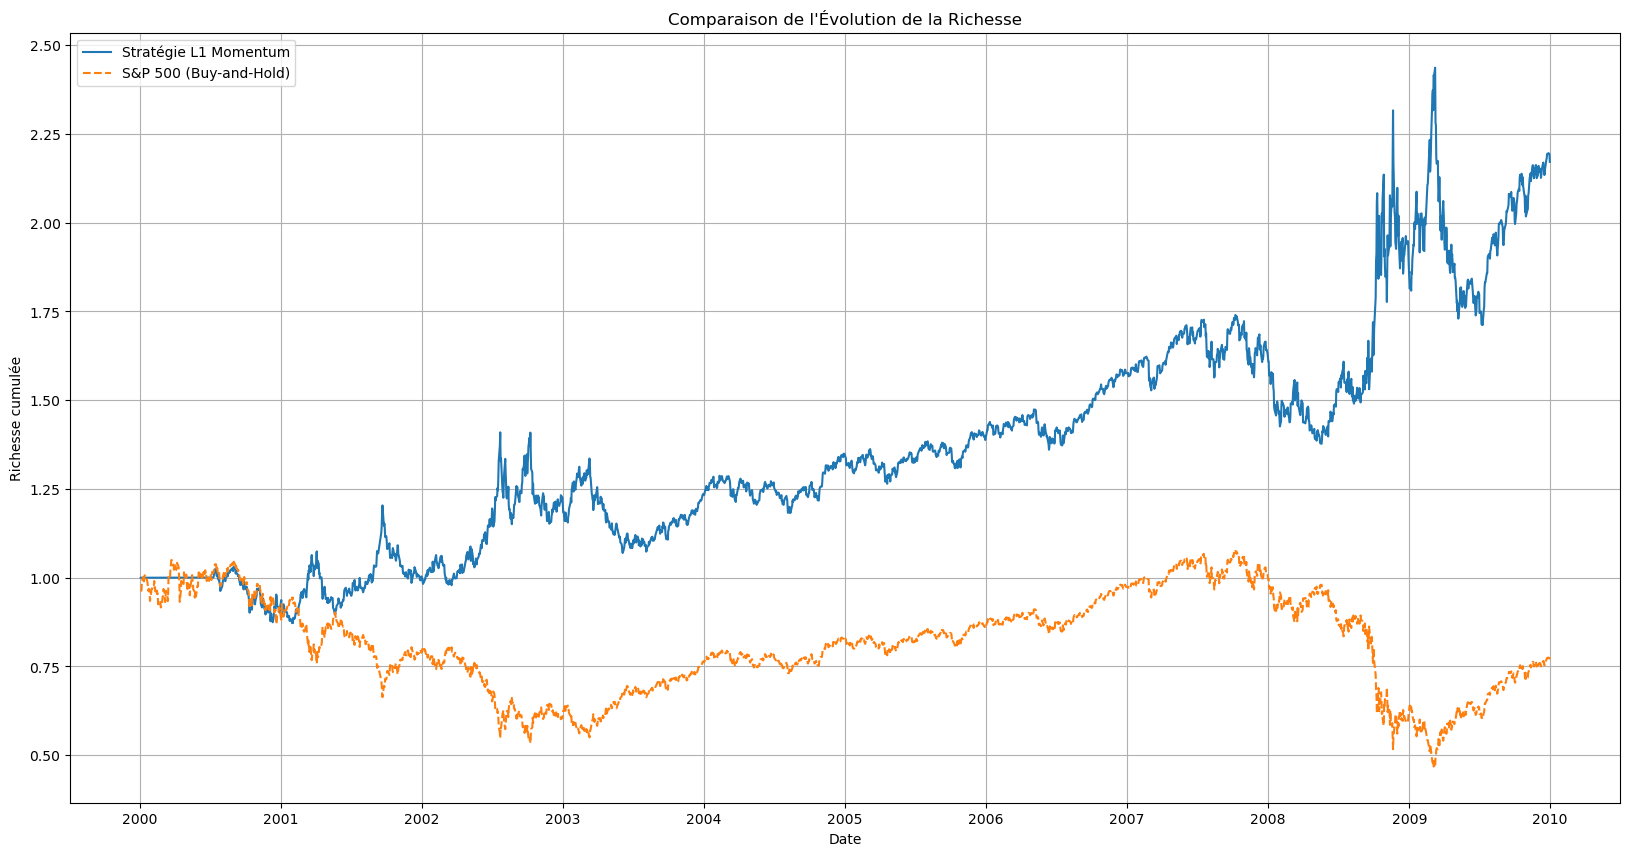

In [23]:
import numpy as np
import pandas as pd
import yfinance as yf
import cvxpy as cp
import matplotlib.pyplot as plt

# 1. Fonction de filtrage L1
def l1_filter(data, lambda_val=100):
    n = len(data)
    if n < 3:
        raise ValueError("Les données doivent contenir au moins 3 points pour appliquer le filtre L1.")
    x = cp.Variable(n)
    objective = cp.Minimize(0.5 * cp.sum_squares(data - x) + lambda_val * cp.norm1(cp.diff(x, k=2)))
    problem = cp.Problem(objective)
    problem.solve(solver=cp.ECOS)
    return x.value

# 2. Stratégie L1 Momentum
def L1_momentum_strategy(data, w0, curr_vars=None, **kwargs):
    T1 = kwargs.get("T1", 130 * 4)  # Fenêtre long terme
    T2 = kwargs.get("T2", 130)      # Fenêtre court terme
    risk = kwargs.get("risk", 0.001)
    if curr_vars is None:
        curr_vars = {"asset.alloc": 0}
    if len(data) < T2:
        return curr_vars
    log_data = np.log(data)
    trend = l1_filter(log_data[-T1:], lambda_val=100)
    pred_mu = trend[-1] - trend[-2]
    vol = np.mean(np.diff(log_data[-T2:]) ** 2)
    asset_alloc = pred_mu / (risk * w0 * vol)
    curr_vars['asset.alloc'] = np.clip(asset_alloc, -1, 1)
    return curr_vars

# 3. Backtest
def backtest(strategy, start, end, data, rf_rate, w0, transact_cost=1e-3, **strategy_params):
    data = data.loc[start:end]
    rf_rate = rf_rate.loc[start:end]
    dates = data.index
    signals = []
    curr_vars = None
    for i in range(1, len(dates)):
        window_data = data.iloc[:i]
        curr_vars = strategy(window_data.values, w0, curr_vars, **strategy_params)
        signals.append(curr_vars['asset.alloc'])
    results = {
        'backtest_dates': dates[1:],
        'weights': np.array(signals),
        'risky': data.iloc[1:].values.flatten(),
        'rf': rf_rate.iloc[1:].values.flatten(),
        'initial_wealth': w0
    }
    return results

# 4. Comparaison avec le S&P 500
def compare_with_benchmark(bt_result, sp500_prices):
    weights = bt_result['weights']
    risky_returns = np.diff(bt_result['risky']) / bt_result['risky'][:-1]
    rf = bt_result['rf']
    
    # Richesse de la stratégie
    wealth = [bt_result['initial_wealth']]
    for t in range(len(risky_returns)):
        daily_return = weights[t] * risky_returns[t] + (1 - weights[t]) * rf[t]
        wealth.append(wealth[-1] * (1 + daily_return))
    wealth = np.array(wealth)
    
    # Richesse S&P 500 (Buy-and-Hold)
    sp500_returns = np.diff(sp500_prices) / sp500_prices[:-1]
    sp500_wealth = np.cumprod(1 + np.append(0, sp500_returns)) * bt_result['initial_wealth']
    
    # Visualisation
    plt.figure(figsize=(20, 10))
    plt.plot(bt_result['backtest_dates'], wealth, label="Stratégie L1 Momentum")
    plt.plot(bt_result['backtest_dates'], sp500_wealth[1:], label="S&P 500 (Buy-and-Hold)", linestyle="--")
    plt.title("Comparaison de l'Évolution de la Richesse")
    plt.xlabel("Date")
    plt.ylabel("Richesse cumulée")
    plt.legend()
    plt.grid()
    plt.show()

# 5. Exécution
if __name__ == "__main__":
    # Télécharger les données
    ticker = "^GSPC"
    print("Téléchargement des données...")
    data = yf.download(ticker, start="2000-01-01", end="2023-01-01")['Close']
    rf_rate = pd.Series(0.001 / 252, index=data.index)  # Taux sans risque quotidien constant

    # Paramètres
    T1 = 130 * 4  # Fenêtre long terme
    T2 = 130      # Fenêtre court terme

    # Backtest
    print("Exécution du backtest...")
    results = backtest(L1_momentum_strategy, start="2000-01-01", end="2010-01-01", 
                       data=data, rf_rate=rf_rate, w0=1, T1=T1, T2=T2)

    # Comparaison avec le benchmark (S&P 500)
    compare_with_benchmark(results, data.loc["2000-01-01":"2010-01-01"].values)
